# Assignment 4 - Neural Networks
*Version 1.2. Updated 2021.03.05*

## *Maobin Guo*
Netid: mg471

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), which is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space for optimized application.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools.

# 1

## [50 points] Get to know your networks
The goal of this exercise is to better understand some of the key parameters used in neural networks so that you can be better prepared to tune your model. We'll be using the example data and data generation function below throughout this exercise. 

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data generation function to create a checkerboard-patterned dataset
def make_data_checkerboard(n, noise=0):
    n_samples = int(n/4)
    scale = 5
    shift = 2.5
    center = 0.5
    c1a = (np.random.rand(n_samples,2)-center)*scale + [-shift, shift]
    c1b = (np.random.rand(n_samples,2)-center)*scale + [shift, -shift]
    c0a = (np.random.rand(n_samples,2)-center)*scale + [shift, shift]
    c0b = (np.random.rand(n_samples,2)-center)*scale + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    # Randomly flips a fraction of the labels to add noise
    for i,value in enumerate(y):
        if np.random.rand() < noise:
            y[i] = 1-value
    return (X,y)

# Training datasets (we create 3 to use to average over model)
np.random.seed(88)
N = 3
X_train = []
y_train = []
for i in range(N):
    Xt,yt = make_data_checkerboard(500, noise=0.25)
    X_train.append(Xt)
    y_train.append(yt)
    
# Validation and test data
X_val,y_val = make_data_checkerboard(3000, noise=0.25)
X_test,y_test = make_data_checkerboard(3000, noise=0.25)

# For the final performance evaluation, train on all of the training and validation data:
X_train_plus_val = np.concatenate((X_train[0], X_train[1], X_train[2], X_val), axis=0)
y_train_plus_val = np.concatenate((y_train[0], y_train[1], y_train[2], y_val), axis=0)

The key parameters we want to explore the impact of are: learning rate, batch size, regularization coefficient, and the model architecture (number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem. For all of the settings we'll explore, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

You'll notice we're eliminating early stopping so that we train the network the same amount for each setting. This allows us to compare the operation of the neural network while holding that value constant. Typically the amount of training would be another parameter to analyze the performance of.

**(a)** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each setting plot the decision boundary on the training data (since there are 3 training sets provided, use the first one to train on):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant 2: (2,2), (5,5), (30,30)
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters not only on the mode output, but will also provide insight into a number of other important aspects of neural networks including: learning curves, batch size, and most importantly, the output of each intermediate neuron so that you can visualize the how neurons interact allowing you to combine them for more complex, nonlinear decision boundaries. As you're noting this, experiment by adding or removing hidden layers and neurons per layer. Vary the learning rate, regularization, and other settings.

In [18]:
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

def subplot_decision_boundary(model, X_train, y_train, sub_ax):
    step_size = .02
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    mpl.fit(X_train, y_train)

    df = pd.DataFrame(data={"x0": [x[0] for x in X_train],
                            "x1": [x[1] for x in X_train]})

    # Plot the decision boundary.
    x_min, x_max = int(df.x0.min() - 1.5), int(df.x0.max() + 1.5)
    y_min, y_max = int(df.x1.min() - 1.5), int(df.x1.max() + 1.5)

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                         np.arange(y_min, y_max, step_size))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.subplot(*sub_ax)

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    sns.scatterplot(data = df, x="x0", y="x1", hue=y_train, palette="deep")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

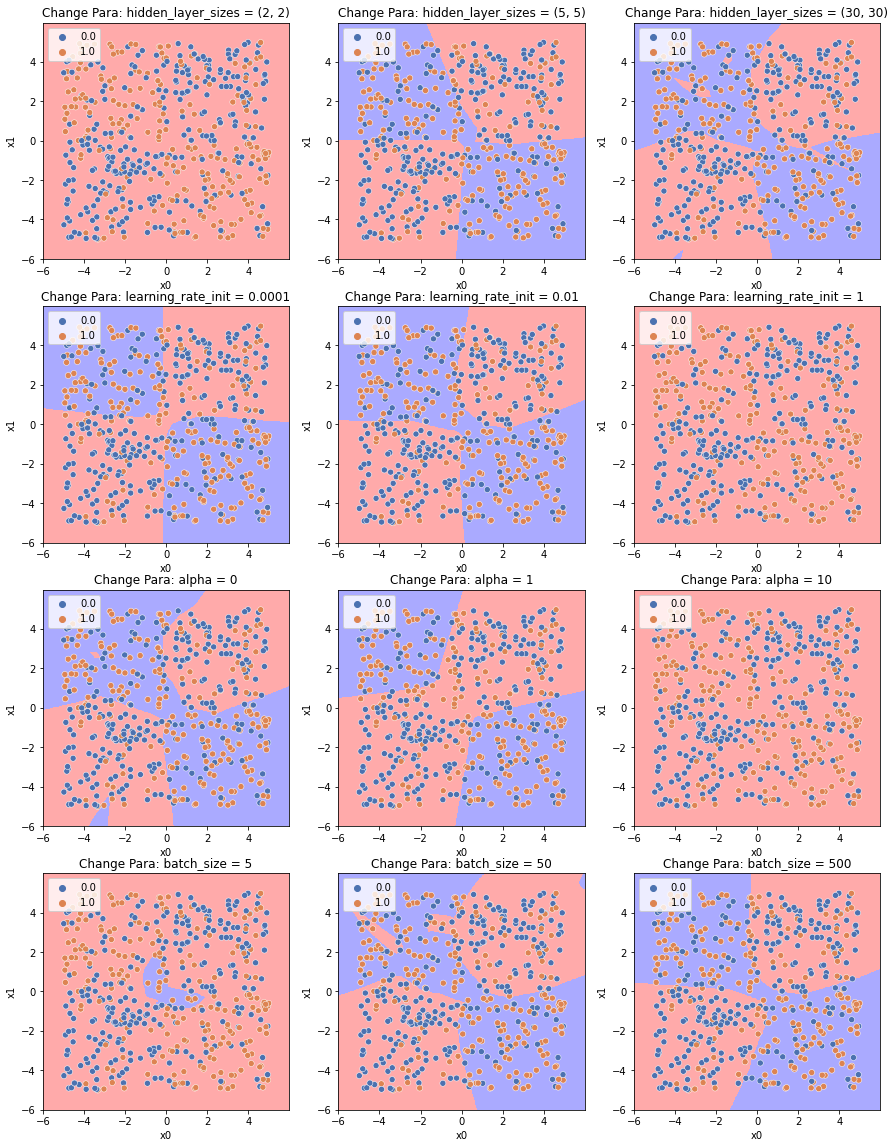

In [52]:
para_hls = [(2,2),  (5,5), (30,30)]
para_lr  = [0.0001, 0.01,  1]
para_reg = [0, 1, 10]
para_bz  = [5, 50, 500]

change_para = {
    "hidden_layer_sizes" : para_hls,
    "learning_rate_init" : para_lr,
    "alpha"              : para_reg, 
    "batch_size"         : para_bz
}

def_para = {
    "learning_rate_init" :  0.03,
    "hidden_layer_sizes" : (30,30),
    "alpha"              : 0,
    "solver"             : 'sgd',
    "tol"                : 1e-5,
    "early_stopping"     : False,
    "activation"         : 'relu',
    "n_iter_no_change"   : 1000,
    "batch_size"         : 50,
    "max_iter"           : 500
}

index = 0
fig = plt.figure(figsize=(15, 20))

for para, vals in change_para.items():
    for v in vals:
        index += 1
        
        arg = def_para.copy()
        arg[para] = v
        mpl = MLPClassifier(**arg)
             
        subplot_decision_boundary(mpl, X_train[0], y_train[0], (4, 3, index))
        
        plt.title("Change Para: {} = {}".format(para, v))
        

**(b)** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your algorithm on the validation dataset (here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other); therefore, use the `score` method of the `MLPClassifier` for this. Create plot of accuracy vs each parameter you vary (this will be three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Since neural networks can be sensitive to initialization values, run each of the settings above 3 times, and report the average accuracy in your plots (do not report the individual accuracy).
- Based on the results report your optimal choices for each of these hyperparameters and why you selected them.
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

In [2]:
def evaluate_model_once(model, X_train, y_train):
    model.fit(X_train, y_train)
    accu = model.score(X_val, y_val)
    return accu


def evaluate_model(para_dic):
    accu_list = []
    for i in range (0, 3):
        mpl = MLPClassifier(**para_dic)
        accu_list.append(evaluate_model_once(mpl, X_train[i], y_train[i]))

    return np.average(accu_list)

def evaluate_model_with_diff_para(name, values, xlab, xlog=True):
    accu_hist = []
    for r in values:
        arg = def_para.copy()
        arg[name] = r
        accu_hist.append(evaluate_model(arg))
    ax = sns.lineplot(x=values, y=accu_hist)

    if xlog:
        ax.set(xscale="log")

    plt.title("Accuracy for different {}".format(xlab))

    if xlog:
        plt.xlabel("{} (Log)".format(xlab))
    else:
        plt.xlabel(xlab)
    plt.ylabel("Accuracy")
    plt.show()

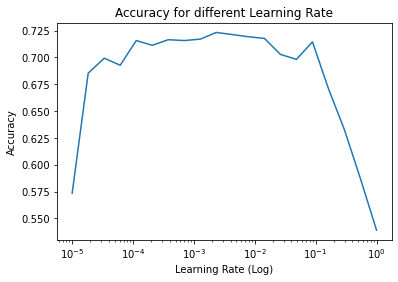

In [62]:
lr = np.logspace(-5, 0, num=20)
evaluate_model_with_diff_para("learning_rate_init", lr, "Learning Rate")

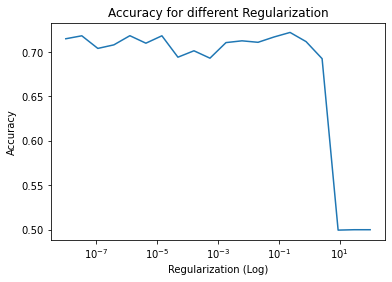

In [65]:
reg = np.logspace(-8, 2, num=20)
evaluate_model_with_diff_para("alpha", reg, "Regularization")

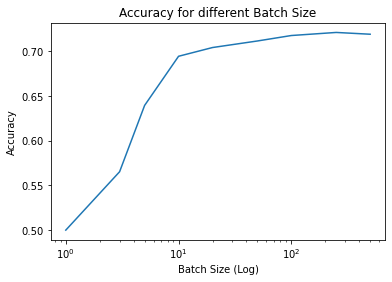

In [67]:
batch_size = [1, 3, 5, 10, 20, 50, 100, 250, 500]
evaluate_model_with_diff_para("batch_size", batch_size, "Batch Size")

According to the plots, I would select following parameters:
- learning rate: 10e-3
- Regularization: 10e-1
- batch size: Batch size: 100

**(c)** Next we want to explore the impact of the model architecture but this means varying two parameters instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2) and (25,25) are valid, but (2,5,3) is not). Use the optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
As in part (b), repeat this evaluation 3 times once for each of the three training sets, and report the average accuracy in your plots across those three trials (do not report the individual accuracy). For plotting these results use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code on creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights. 
- What do the results show? Which parameters did you select and why?

In [5]:
layer_list = [1,2,3,4]
node_list = [1,2,3,4,5,10,15,25,30]

# Optimized default parameter
def_para = {
    "learning_rate_init" : 1e-3,
    "hidden_layer_sizes" : (30,30),
    "alpha"              : 1e-1,
    "solver"             : 'sgd',
    "tol"                : 1e-5,
    "early_stopping"     : False,
    "activation"         : 'relu',
    "n_iter_no_change"   : 1000,
    "batch_size"         : 100,
    "max_iter"           : 500
}



In [ ]:
accu_matrix = []

for layer in layer_list:
    node_accu = []
    for node in node_list:
        arg = def_para.copy()
        arg["hidden_layer_sizes"] = [node] * layer
        accu = evaluate_model(arg)
        node_accu.append(round(accu, 2))
    accu_matrix.append(node_accu)
    
df = pd.DataFrame(accu_matrix, columns=node_list)

Text(0.5, 1.0, 'Accuracy heatmap')

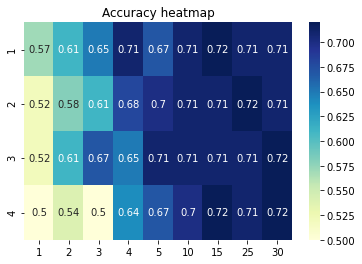

In [11]:


ax = sns.heatmap(df, annot=True, cmap="YlGnBu")
ax.set_xticklabels(node_list)
ax.set_yticklabels(layer_list)
ax.set_title("Accuracy heatmap")


**Answer:** I would select 2 layer and each  15 nodes.

**(d)** Based the optimal choice of hyperparameters and train your model with your optimized hyperparameters on all the training data (all three sets) AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes if you complete that question).

In [18]:
from sklearn import metrics

# Best parameter

def_para = {
    "learning_rate_init" : 1e-3,
    "hidden_layer_sizes" : (3,30),
    "alpha"              : 1e-1,
    "solver"             : 'sgd',
    "tol"                : 1e-5,
    "early_stopping"     : False,
    "activation"         : 'relu',
    "n_iter_no_change"   : 1000,
    "batch_size"         : 100,
    "max_iter"           : 500
}

mpl = MLPClassifier(**def_para)
mpl.fit(X_train_plus_val, y_train_plus_val)
 
 
y_pred = mpl.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("The final model's accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))

The final model's accuracy: 0.71


**(e)** **Automated hyperparameter search**. The manual, greedy approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it does limit our ability to more deeply search the hyperparameter space. Now we'll use a Scikit-Learn tool to search our hyperparameter space. Use [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) to select the hyperparameters by training on ALL of the training and validation data (it will perform cross validation internally). You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this. Grid search searches all possible combinations of values entered as possible values. Doing this over a large hyperparameter space for a model that takes awhile to run is intractable. Random search has been shown to be surprisingly effective in these situations at identifying excellent 
- Set the number of iterations to at least 25 (you'll look at 25 random pairings of possible parameters). You can go as high as you want, but it will take longer the larger this value is.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems (except this time, you'll search over all the parameters at once). You can use lists of values for batch_size, `loguniform` for the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter.
- Once the model is fit, use the `best_params_` attribute to extract the optimized values of the parameters
- State the accuracy of the model on the test dataset
- Plot the ROC curve corresponding to your best model through greedy hyperparameter section vs the model identified through random search. In the legend of the plot, report the AUC for each curve
- Plot the final decision boundary for the greedy and random search-based classifiers along with one of the training datasets to demonstrate the shape of the final boundary
- How did the performance compare?

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from time import time

def_para = {
    "learning_rate_init" : 1e-3,
    "hidden_layer_sizes" : (3,30),
    "alpha"              : 1e-1,
    "solver"             : 'sgd',
    "tol"                : 1e-5,
    "early_stopping"     : False,
    "activation"         : 'relu',
    "n_iter_no_change"   : 1000,
    "batch_size"         : 100,
    "max_iter"           : 500
}

para_list = {
    "learning_rate_init" : np.logspace(-5, 0, num=20),
    "hidden_layer_sizes" : [(2,2),  (5,5), (30,30)],
    "alpha"              : np.logspace(-8, 2, num=20),
    "batch_size"         : [1, 3, 5, 10, 20, 50, 100, 250, 500],
}

mpl = MLPClassifier(def_para)

# run randomized search
n_iter_search = 25
random_search = RandomizedSearchCV(mpl, n_jobs = 3,
                                   param_distributions=para_list,
                                   n_iter=n_iter_search)


start = time()
random_search.fit(X_train_plus_val, y_train_plus_val)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

RandomizedSearchCV took 627.50 seconds for 25 candidates parameter settings.


NameError: name 'report' is not defined

In [10]:
best_para = random_search.best_params_  
print(best_para)

{'learning_rate_init': 0.007847599703514606, 'hidden_layer_sizes': (5, 5), 'batch_size': 500, 'alpha': 0.006158482110660254}


In [13]:
from sklearn import metrics

mpl = MLPClassifier(**best_para)
mpl.fit(X_train_plus_val, y_train_plus_val)

y_pred = mpl.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("The best para model's accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))

The best para model's accuracy: 0.73


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['para', 'fpr','tpr','auc'])

mpl = MLPClassifier(**def_para)
mpl.fit(X_train_plus_val, y_train_plus_val)

yproba = mpl.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  yproba)
auc = roc_auc_score(y_test, yproba)    
result_table = result_table.append({'para':"Greedy",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc}, ignore_index=True)

mpl = MLPClassifier(**best_para)
mpl.fit(X_train_plus_val, y_train_plus_val)

yproba = mpl.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  yproba)
auc = roc_auc_score(y_test, yproba)    
result_table = result_table.append({'para':"Random",
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('para', inplace=True)

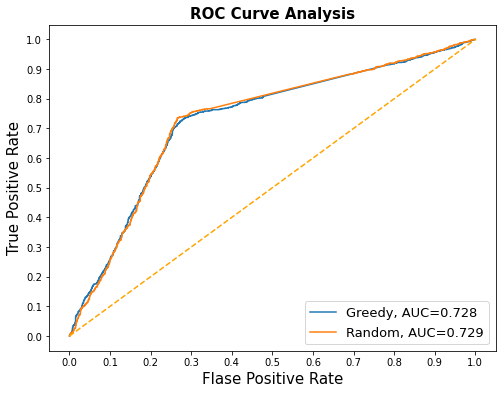

In [17]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Text(0.5, 1.0, 'Randomized Search')

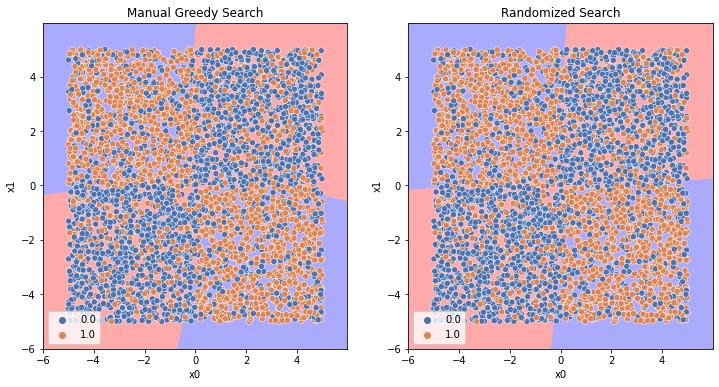

In [21]:
fig = plt.figure(figsize=(12,6))

mpl = MLPClassifier(**def_para)
subplot_decision_boundary(mpl, X_train_plus_val, y_train_plus_val, (1, 2, 1))
plt.title("Manual Greedy Search")

 
mpl = MLPClassifier(**best_para)
subplot_decision_boundary(mpl, X_train_plus_val, y_train_plus_val, (1, 2, 2))
plt.title("Randomized Search")

# 2

## [50 points] Build and test your own Neural Network for classification

There is no better way to understand how one of the core techniques of modern machine learning works than to build a simple version of it yourself. In this exercise you will construct and apply your own neural network classifier. You may use numpy if you wish but no other libraries.

**(a)** Create a neural network class that follows the `scikit-learn` classifier convention by implementing `fit`, `predict`, and `predict_proba` methods. Your `fit` method should run backpropagation on your training data using stochastic gradient descent. Assume the activation function is a sigmoid. Choose your model architecture to have two input nodes, two hidden layers with five nodes each, and one output node.

To guide you in the right direction with this problem, please find a skeleton of a neural network class below. You absolutely MAY use additional methods beyond those suggested in this template, but the methods listed below are the minimum required to implement the model cleanly.

**Strategies for debugging**. One of the greatest challenges of this implementations is that there are many parts and a bug could be present in any of them. Here are some recommended tips:
- *Development environment*. Consider using an Integrated Development Environment (IDE). Jupyter is great, but not always the easiest for debugging. There are a number of IDE's out there and something like PyCharm or Spyder. For a video on using and debugging in Spyder, see [my video on this topic](https://www.youtube.com/watch?v=zYNRqVimU3Q).
- *Unit tests*. I would strongly encourage you to create unit tests for most modules. Without doing this will make your code extremely difficult to bug. You can create simple examples to feed through the network to validate it is correctly computing activations and node values. Also, if you manually set the weights of the model, you can even calculate backpropagation by hand for some simple examples (admittedly, that unit test would be challenging and is optional, but a unit test is possible). 
- *Compare against a similar architecture*. You can also verify the performance of your overall neural network by comparing it against the `scikit-learn` implementation and using the same architecture and parameters as your model (your model outputs will certainly not be identical, but they should be somewhat similar).

**(b)** Apply your neural network. 
- Create a training and validation dataset using `sklearn.datasets.make_moons(N, noise=0.20)`, where $N_{train} = 500$ and $N_{test} = 100$. 
- Train and test your model on this dataset plotting your learning curves (training and validation error for each epoch of stochastic gradient descent, where an epoch represents having trained on each of the training samples one time). 
- Tune the learning rate and number of training epochs for your model to improve performance as needed. 
- In two subplots, plot the training data on one subplot, and the validation data on the other subplot. On each plot, also plot the decision boundary from your neural network trained on the training data. 
- Report your performance on the test data with an ROC curve and compare against the `scikit-learn` `MLPClassifier` trained with the same parameters.

**(c)** Suggest two ways in which you neural network implementation could be improved: are there any options we discussed in class that were not included in your implementation that could improve performance?

In [ ]:
class myNeuralNetwork(object):
    
    def __init__(self, n_in, n_layer1, n_layer2, n_out, learning_rate=):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
            
    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
    
    def compute_loss(self, X, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
    
    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network
    
            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''
        
    def stochastic_gradient_descent_step(self):
        '''stochastic_gradient_descent_step
        Using the gradient values computed by backpropagate, update each
        weight value of the model according to the familiar stochastic
        gradient descent update equation.
        
        Input: none
        Output: none
        '''
    
    def fit(self, X, y, max_epochs=, learning_rate=, get_validation_loss=):
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''
            
    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
    
    def predict(self, X, decision_thresh=):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''
    
    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
    
    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
